In [66]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import torch
import torchaudio
import torchaudio.functional as F
import librosa
import pandas as pd
import numpy as np
import os
import random
import pickle

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from IPython.display import Audio, display
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
def load_audio(file_path, sr=None):
    try:
        audio_data, sampling_rate = librosa.load(file_path, sr=sr)
        return audio_data, sampling_rate
    except Exception as e:
        print(f"Error reading audio file: {e}")
        return None, None


def downsample_audio(audio, original_sr, target_sr):
    return librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)


def audio_to_melspectrogram(audio, sampling_rate, hop_length=256, n_fft=2048):
    spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sampling_rate, hop_length=hop_length, n_fft=n_fft
    )
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def cut_random_segment(audio, segment_size):
    max_start_time = max(0, len(audio) - segment_size)
    start_time = np.random.randint(0, max_start_time)
    return audio[start_time : (start_time + segment_size)]


def show_melspectrogram(
    spectrogram, sampling_rate, title="log-frequency power spectrogram"
):
    librosa.display.specshow(spectrogram, x_axis="time", y_axis="mel", sr=sampling_rate)
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()


def show_signal(audio):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()


def show_and_play_signal(audio, sample_rate, title="Signal"):
    plt.plot(audio)
    plt.title(title)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()
    display(Audio(audio, rate=sample_rate))


def read_as_melspectrogram(file_path):
    audio, sampling_rate = load_audio(file_path)
    spectrogram = audio_to_melspectrogram(audio, sampling_rate)
    return spectrogram


def apply_effect(waveform, sample_rate, effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    return effector.apply(waveform, sample_rate)


def get_files_by_extension(folder_path, extension="wav"):
    file_list = list()
    for file_name in os.listdir(folder_path):
        if file_name.endswith(extension):
            file_path = os.path.join(folder_path, file_name)
            file_list.append(file_path)
    return file_list


def create_rir_bank(wav_list, sample_rate):
    bank = dict()
    for wav_path in tqdm(wav_list):
        waveform, original_sr = load_audio(wav_path)

        if original_sr > sample_rate:
            waveform = downsample_audio(waveform, original_sr, sample_rate)

        if waveform[-int(len(waveform) * 0.5) :].std() > 0.001:
            continue

        rir = waveform[:sample_rate]
        rir = rir / (np.linalg.norm(rir, ord=2) + 1e-6)

        bank[os.path.basename(wav_path)] = rir

    return bank


def save_to_pickle(dictionary, file_path):
    with open(file_path, "wb") as file:
        pickle.dump(dictionary, file)

In [54]:
rir_path = "/media/klig/disk/datasets/rir-noises/real_rirs_isotropic_noises"
rir_list = get_files_by_extension(rir_path, "wav")

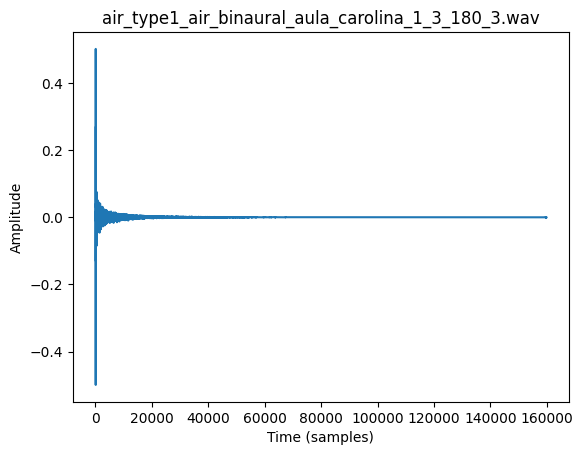

In [122]:
sample_wav = random.choice(rir_list)
waveform, sample_rate = load_audio(sample_wav)
show_and_play_signal(waveform, sample_rate, os.path.basename(sample_wav))

In [123]:
waveform[-int(len(waveform) * 0.5) :].std()

4.4425764e-05

In [115]:
bank_8k = create_rir_bank(rir_list, 8000)
save_to_pickle(bank_8k, "bank/rir_8k.pkl")

  0%|          | 0/417 [00:00<?, ?it/s]

In [116]:
bank_16k = create_rir_bank(rir_list, 16000)
save_to_pickle(bank_16k, "bank/rir_16k.pkl")

  0%|          | 0/417 [00:00<?, ?it/s]